(0.0, 20.0)

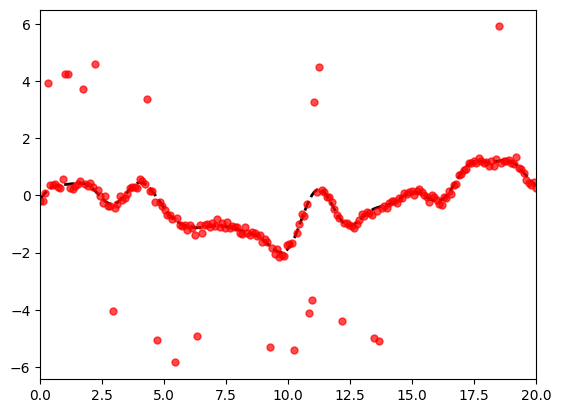

In [2]:
from typing import Optional

import tensorflow as tf
import numpy as np
from check_shapes import check_shapes, inherit_check_shapes
from typing import Optional, Tuple, Type, Union, cast
import tensorflow_probability as tfp
import gpflow

from gpflow.base import InputData, MeanAndVariance, RegressionData, TensorData
from gpflow.kernels import Kernel
from gpflow.likelihoods import Gaussian
from gpflow.mean_functions import MeanFunction
from gpflow.models.model import GPModel
from gpflow.models.training_mixins import InternalDataTrainingLossMixin
from gpflow.models.util import data_input_to_tensor
from gpflow.config import default_float, default_jitter
from gpflow.utilities import to_default_float
from gpflow import posteriors
from gpflow.utilities.ops import eye
import random

from tensorflow.python.keras.engine.training_utils_v1 import check_num_samples

import w 

import tensorflow as tf
import numpy as np
import gpflow

import matplotlib.pyplot as plt
tf.keras.config.set_floatx('float64')
seed = 10

#set seed
np.random.seed(seed)
tf.random.set_seed(seed)

#create X
n_points = 200
sigma_n = 0.1
#percentage of points in x which are biased
percent_miss=0.1


#
lengthscale = 1
variance = 1

variance_out = 2

kernel=gpflow.kernels.SquaredExponential(lengthscales=lengthscale, variance=variance)

x = np.linspace(0, 20, n_points).reshape(n_points, 1)
f = np.random.multivariate_normal(mean=np.zeros(len(x)) ,cov=kernel(x, x)).reshape(n_points, 1)

i_obs = np.random.choice(
    np.arange(0, n_points, 1), int( n_points), replace=False)

y_obs = f[i_obs] + np.random.normal(scale=sigma_n, size=n_points).reshape(n_points, 1)
x_obs = x[i_obs]

arr1inds = x_obs[:,0].argsort()
x_obs = x_obs[arr1inds]
y_obs = y_obs[arr1inds]

i_mis = np.random.choice(
    np.arange(0, n_points, 1), int(percent_miss * n_points), replace=False)

y_mis_pos = y_obs[i_mis[(y_obs[i_mis]>0)[:,0]]]  + np.random.uniform(3, 5, size=len(i_mis[(y_obs[i_mis]>0)[:,0]])).reshape(len(i_mis[(y_obs[i_mis]>0)[:,0]]),1)
y_mis_neg = y_obs[i_mis[(y_obs[i_mis]<=0)[:,0]]]  - np.random.uniform(3, 5, size=len(i_mis[(y_obs[i_mis]<=0)[:,0]])).reshape(len(i_mis[(y_obs[i_mis]<=0)[:,0]]),1)
y_obs[i_mis[(y_obs[i_mis]>0)[:,0]]] = y_mis_pos
y_obs[i_mis[(y_obs[i_mis]<=0)[:,0]]] = y_mis_neg
X=x
y=y_obs

plt.plot(x, f, color='black', ls='--', lw=2)
plt.plot(x_obs, y_obs, 'r.', ms=10, alpha=0.7)
plt.xlim(x[0], x[-1])

In [3]:

standard_gp = gpflow.models.SVGP(
    (x_obs, y_obs),
    kernel=gpflow.kernels.SquaredExponential(lengthscales=lengthscale, variance=variance),
    noise_variance=sigma_n**2
)

f_mean, f_var = standard_gp.predict_f(x, full_cov=False)

f_std = np.sqrt(f_var)

TypeError: Error calling wrapped function (see above error). If you believe your parameters actually are correct, the error can sometimes be fixed by setting `tf_decorator=True` on your `@check_shapes` decorator.

NameError: name 'f_mean' is not defined

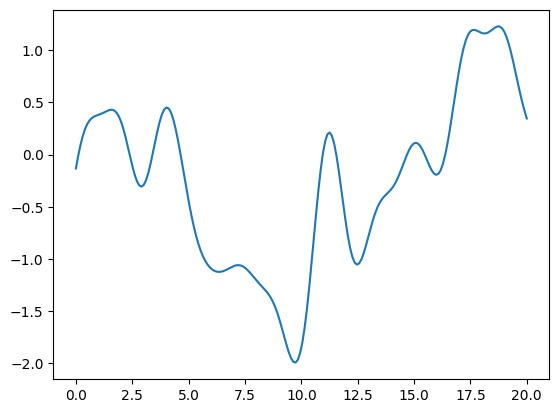

In [4]:
plt.plot(x,f)
plt.plot(x,f_mean)
plt.legend()

In [5]:

def update_mu_u(alpha, Sigma_a_inv, J_w_inv, sigma_2, Y_train, mu_w,K_u_x,K_uu_inv):
    sum_K_j=sigma_2**(-2)*J_w_inv[0,0]*tf.matmul(K_u_x[:,0:1],tf.transpose(K_u_x[:,0:1]))
    for i in range(1,len(J_w_inv)):
        sum_K_j+=sigma_2**(-2)*J_w_inv[i,i]*tf.matmul(K_u_x[:,i:(i+1)],tf.transpose(K_u_x[:,i:(i+1)]))
    q1 = tf.linalg.inv(alpha * Sigma_a_inv + tf.matmul(K_uu_inv,sum_K_j)@K_uu_inv)
    q2 = tf.matmul(( K_uu_inv@K_u_x@J_w_inv/ sigma_2), (Y_train - mu_w))
    return tf.matmul(q1, q2)


def update_Sigma_u(sigma_2, J_w_inv,K_uu_inv,K_u_x):
    """
    Compute the updated value of Sigma_f.

    Parameters:
        c_f (float): Scaling constant.
        K (Tensor): Kernel matrix.
        sigma_2 (float): Noise variance.
        J_w (Tensor): Weight matrix.

    Returns:
        Tensor: The updated value of Sigma_f.
    """
    sum_K_j=sigma_2**(-2)*J_w_inv[0,0]*K_u_x[:,0:1]*tf.transpose(K_u_x[:,0:1])
    for i in range(1,len(J_w_inv)):
        sum_K_j+=sigma_2**(-2)*J_w_inv[i,i]*K_u_x[:,i:(i+1)]*tf.transpose(K_u_x[:,i:(i+1)])
    return  tf.linalg.inv(K_uu_inv*sum_K_j*K_uu_inv+K_uu_inv)


def divide_batch(X, y, test_ratio=0.2, seed=None):
    if seed is None:
        seed = np.random.uniform(0, 1000)

    random.seed(seed)

    # Get the number of samples
    n = tf.shape(X)[0]
    num_test = tf.cast(tf.math.round(test_ratio * tf.cast(n, tf.float32)), tf.int32)

    # Shuffle indices
    indices = tf.range(n)
    shuffled_indices = tf.random.shuffle(indices)

    # Split indices
    test_indices = shuffled_indices[:num_test]
    train_indices = shuffled_indices[num_test:]

    # Split data
    X_train = tf.gather(X, train_indices)
    X_test = tf.gather(X, test_indices)
    Y_train = tf.gather(y, train_indices)
    Y_test = tf.gather(y, test_indices)
    return X_train, Y_train, X_test, Y_test, train_indices, test_indices


def maximize_c(y, quant):
    return np.quantile(abs(y), 1 - quant)


def Full_sample_estimate(variance, lengthscale,X_u,X,w_full, c_f, alpha, Y):
    kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(variance, lengthscale)
    J_w_inv = tf.linalg.tensor_diag(tf.squeeze(tf.math.pow(w_full, 2)))

    
    K_uu = kernel.matrix(X_u, X_u)
    K_ux_train= kernel.matrix(X_u, X)
    Sigma_u = update_Sigma_u(sigma**2, J_w_inv,tf.linalg.inv(K_uu),K_ux_train)
    Sigma_u = c_f*Sigma_u
    Sigma_a = alpha * K_uu + (1 - alpha) * Sigma_u
    Sigma_a_inv = tf.linalg.inv(Sigma_a)
    mu_u =update_mu_u(alpha, Sigma_a_inv, J_w_inv, sigma ** 2, Y, m_w_full,K_ux_train,tf.linalg.inv(K_uu))
    
    K_star = tf.transpose(kernel.matrix(X, X_u))
    K_star_star = kernel.matrix(X, X)

    mu_f_pred = tf.transpose(K_star) @ tf.linalg.inv(K_uu) @ mu_u
    sigma_f_pred = K_star_star
    sigma_f_pred = sigma_f_pred - c_f * tf.transpose(K_star) @ tf.linalg.inv(K_uu + sigma ** 2 *tf.linalg.eye(cN,cN,dtype=tf.float64)) @ K_star
    sigma_f_pred = sigma_f_pred + (c_f - 1) * tf.transpose(K_star) @ tf.linalg.inv(K_uu) @ K_star + tf.linalg.eye(200, dtype=tf.float64) * sigma**2
    sigma_f_pred=tf.linalg.diag_part(sigma_f_pred)#*tf.gather(w_full, test_indices)**(-2)
    
    return (mu_f_pred, sigma_f_pred)

    




import random
import w
c = maximize_c(y, 0.1)

W = w.IMQ(c)
w_full = tf.cast(W.W(X, y), dtype=tf.float64)
m_w_full = W.dy(X, y) ** 2

sigma = tf.Variable(1, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
c_f = tf.Variable(1., dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
variance = tf.Variable(4.5, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
lengthscale = tf.Variable(4, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
alpha = tf.Variable(0.5, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, -1, 2))

X_u=tf.constant(tf.range(1,21,1, dtype=tf.float64),shape=[20,1])
cN=20
def mean_function(X):
    return tf.zeros(tf.shape(X)[0], dtype=tf.float64)


import tensorflow_probability as tfp

for i in range(100):
    print(i)
    #create batch for the iteration
    X_train, Y_train, X_test, Y_test, train_indices, test_indices = divide_batch(X, y, test_ratio=0.2, seed=1)
    n_test = X_test.shape[0]
    #estimate Gpflow kernel.
    kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(variance, lengthscale)
    K_uu = kernel.matrix(X_u, X_u)
    K_ux_train= kernel.matrix(X_u, X_train)
    
    #EXTRACT TRAIN INDEXES I
    new_ind = list(train_indices.numpy())
    #update quantitites, Sigma_a,J_w
    w_train = tf.gather(w_full, train_indices)
    m_w = tf.gather(m_w_full, train_indices)
    J_w = tf.linalg.tensor_diag(tf.squeeze(tf.math.pow(w_train, -2)))
    J_w_inv = tf.linalg.tensor_diag(tf.squeeze(tf.math.pow(w_train, 2)))

    #UPDATE VARIANCE OF f_u
    Sigma_u = update_Sigma_u(sigma**2, J_w_inv,tf.linalg.inv(K_uu),K_ux_train)
    Sigma_u =c_f*Sigma_u
    Sigma_a = alpha * K_uu + (1 - alpha) * Sigma_u
    Sigma_a_inv = tf.linalg.inv(Sigma_a)
    
    #UPDATE MEAN OF f_u
    mu_u = update_mu_u(alpha, Sigma_a_inv, J_w_inv, sigma ** 2, Y_train, m_w,K_ux_train,tf.linalg.inv(K_uu))
    
        
    #KERNEL BETWEEN U AND X_TEST
    with tf.GradientTape(persistent=True) as tape:
        K_star = tf.transpose(kernel.matrix(X_test, X_u))
        K_star_star = kernel.matrix(X_test, X_test)
        
        #PREDICTED MEAN for Y_test
        mu_f_pred = tf.transpose(K_star) @ tf.linalg.inv(K_uu) @ mu_u
        
        #COMPUTE LOSS
        vv =(Y_test-mu_f_pred)
        loss = tf.reduce_mean(tf.square(vv))

       
    grad = tape.gradient(loss, [c_f, sigma, variance, lengthscale, alpha])
    optimizer = tf.optimizers.Adam(learning_rate=0.05)
    optimizer.apply_gradients(zip(grad, [c_f, sigma, variance, lengthscale, alpha]))
Mu_full, Sigma_full1 = Full_sample_estimate(variance, lengthscale,X_u, X, w_full, c_f, alpha, y)


0
1


/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py:678: UserWarning: Gradients do not exist for variables ['Variable:0', 'Variable:0', 'Variable:0'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [6]:
lengthscale


<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=4.339183269743923>

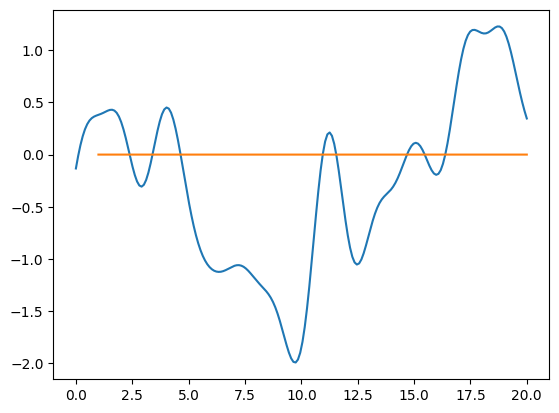

In [8]:
plt.plot(x,f)
plt.plot(X_u,mu_u)
#plt.plot(x,Mu_full)

562.8571428571429

In [9]:
    


@tf.function
def loo_cv(X, y, mean_function, kernel, W, noise_variance, likelihood) -> tf.Tensor:
    r"""
    Computes the leave one out to train the model
    """
    err = y - tf.reshape(mean_function(X), (-1, 1))
    K = kernel.matrix(X, X)
    n = tf.cast(tf.shape(X)[0], K.dtype)

    likelihood_variance = likelihood.variance_at(X)  #####WHAT IS THIS???
    W = IMQ(c)

    W, W_dy = W.w_dy(X, err)
    dylog2 = 2 * likelihood_variance * W_dy / W
    Y_bar = err - dylog2

    K_sW = add_noise_cov(K, tf.squeeze(W, axis=-1), tf.squeeze(likelihood_variance, axis=-1))
    L_sW = tf.linalg.cholesky(K_sW)
    L_sW_inv = tf.linalg.inv(L_sW)

    #K_sW_inv = tf.linalg.matmul(L_sW_inv, L_sW_inv, transpose_a=True)

    #diag_K_sW_inv = tf.reshape(tf.linalg.diag_pxart(K_sW_inv), (-1, 1))
    diag_K_sW_inv = tf.reshape(tf.reduce_sum(L_sW_inv ** 2, axis=0), (-1, 1))

    A = diag_K_sW_inv * dylog2

    #B = tf.matmul(K_sW_inv, Y_bar)
    B = tf.matmul(L_sW_inv, tf.matmul(L_sW_inv, Y_bar), transpose_a=True)
    C = diag_K_sW_inv * (1 - diag_K_sW_inv * (likelihood_variance * (W ** -2) - likelihood_variance))

    D = C / diag_K_sW_inv ** 2

    loo = - 0.5 * tf.reduce_sum(tf.math.log(D))
    loo -= 0.5 * n * np.log(2 * np.pi)
    loo -= 0.5 * tf.reduce_sum((A + B) ** 2 / C)
    return loo




sigma = tf.Variable(0.1, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.1, 10))
variance = tf.Variable(4.5, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
lengthscale = tf.Variable(.9, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))

N = X.shape[0]
W=tf.eye(N,N,dtype=tf.float64)*sigma**2
def mean_function(X):
    return tf.zeros(tf.shape(X)[0], dtype=tf.float64)

for i in range(500):
    print(i)
    kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(variance, lengthscale)
    K = kernel.matrix(X, X)
    K_plus_W_inv=tf.linalg.inv(K+W)
    K_plus_W_inv_y=K_plus_W_inv@y
    mean_loo=tf.squeeze(y)-tf.squeeze(K_plus_W_inv_y)*(1/tf.linalg.diag_part(K_plus_W_inv))
    sigma_loo=1/tf.linalg.diag_part(K_plus_W_inv)
    """vv = tfp.distributions.Normal(mean_loo, sigma_loo)
    LOO_probs=vv.log_prob(tf.squeeze(y))
    W=tf.linalg.tensor_diag(LOO_probs/sum(LOO_probs))*N/sigma**2
    """
    W=tf.eye(N,N,dtype=tf.float64)*sigma**2
    def maximize_c(y, quant):
                return np.quantile(abs(y), 1 - quant)
    c=maximize_c(y-mean_loo,0.1)
    W=1/(1+(tf.squeeze(y)-mean_loo)**2/c**2)*sigma**2
    sigma=tf.sqrt(tf.reduce_mean((tf.squeeze(y)-mean_loo)**2))
    with tf.GradientTape(persistent=True) as tape:
        #number of observations
        W=tf.linalg.tensor_diag(tf.reduce_mean(W)/W)
        #estimate Gpflow kernel.
        K = kernel.matrix(X, X)
        K_plus_W_inv=tf.linalg.inv(K+W)
        marginal=tf.reduce_sum(-0.5 *tf.transpose(y)@K_plus_W_inv@y-tf.math.log(tf.linalg.det(K_plus_W_inv)))
    grad = tape.gradient(marginal, [ variance, lengthscale])
    optimizer = tf.optimizers.Adam()
    optimizer.apply_gradients(zip(grad, [ variance, lengthscale]))
    print( [ sigma, variance, lengthscale])


0
[<tf.Tensor: shape=(), dtype=float64, numpy=1.3762362851131074>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=4.499000006941015>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.900999993291517>]
1
[<tf.Tensor: shape=(), dtype=float64, numpy=1.2858620517460726>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=4.498000013883844>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.901999986582227>]
2
[<tf.Tensor: shape=(), dtype=float64, numpy=1.2838413702950355>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=4.49700002082689>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.9029999798728624>]
3
[<tf.Tensor: shape=(), dtype=float64, numpy=1.2839792368284209>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=4.496000027770135>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.9039999731634303>]
4
[<tf.Tensor: shape=(), dtype=float64, numpy=1.2840007793801165>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=

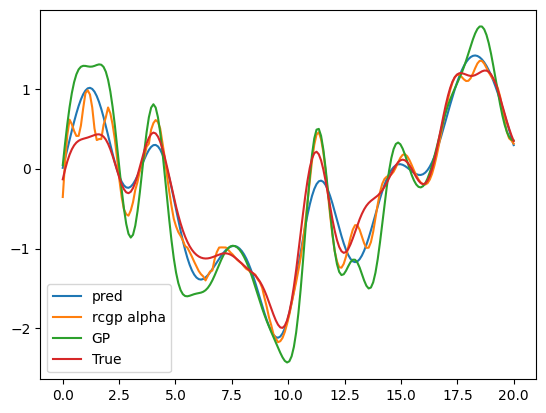

In [6]:
pred=K@K_plus_W_inv@y
#plt.plot(X,y,label="data")
plt.plot(x,pred,label="pred")

plt.plot(X,Mu_full,label="rcgp alpha")
plt.plot(x, f_mean,label="GP")
#
plt.plot(x,f,label="True")
plt.legend()

In [7]:
print(tf.reduce_mean((f-f_mean)**2),"normal mean")
print(tf.reduce_mean((f-Mu_full)**2),"rcgp_alpha mean")
print(tf.reduce_mean((f-pred)**2),"loss mean")



tf.Tensor(0.2128135237527253, shape=(), dtype=float64) normal mean
tf.Tensor(0.03398346832653178, shape=(), dtype=float64) rcgp_alpha mean
tf.Tensor(0.04890491699236011, shape=(), dtype=float64) loss mean


In [8]:

from typing import Optional

import tensorflow as tf
import numpy as np
from check_shapes import check_shapes, inherit_check_shapes
from typing import Optional, Tuple, Type, Union, cast

import gpflow

from gpflow.base import InputData, MeanAndVariance, RegressionData, TensorData
from gpflow.kernels import Kernel
from gpflow.likelihoods import Gaussian
from gpflow.mean_functions import MeanFunction
from gpflow.models.model import GPModel
from gpflow.models.training_mixins import InternalDataTrainingLossMixin
from gpflow.models.util import data_input_to_tensor
from gpflow.config import default_float, default_jitter
from gpflow.utilities import to_default_float
from gpflow import posteriors
from gpflow.utilities.ops import eye


from typing import Any, Callable
import tensorflow as tf
from check_shapes import check_shapes

from gpflow.base import TensorType
from gpflow.likelihoods import Gaussian


def assert_params_false(
    called_method: Callable[..., Any],
    **kwargs: bool,
) -> None:

    errors_str = ", ".join(f"{param}={value}" for param, value in kwargs.items() if value)
    if errors_str:
        raise NotImplementedError(
            f"{called_method.__qualname__} does not currently support: {errors_str}"
        )


def add_noise_cov(K: tf.Tensor, W: tf.Tensor, likelihood_variance: TensorType) -> tf.Tensor:

    k_diag = tf.linalg.diag_part(K)
    return tf.linalg.set_diag(K, k_diag + likelihood_variance*(W**-2))


def add_likelihood_noise_cov(K: tf.Tensor, W: tf.Tensor, likelihood: Gaussian, X: TensorType) -> tf.Tensor:
    W_squeeze = tf.squeeze(W, axis=-1)
    variance_squeeze = tf.squeeze(likelihood.variance_at(X), axis=-1)
    return add_noise_cov(K, W_squeeze, variance_squeeze)



class RCGPR_deprecated(GPModel, InternalDataTrainingLossMixin):
    """
    Robust and Conjugate Gaussian Process Regression
    This method only works with a Gaussian likelihood, its variance is
    initialized to `noise_variance`.
    """
    @check_shapes(
        "data[0]: [N, D]",
        "data[1]: [N, P]",
        "noise_variance: []",
    )
    def __init__(
        self,
        data: RegressionData,
        kernel: Kernel,
        weighting_function,
        mean_function: Optional[MeanFunction] = None,
        noise_variance: Optional[TensorData] = None,
        likelihood: Optional[Gaussian] = None,
    ):
        assert (noise_variance is None) or (
            likelihood is None
        ), "Cannot set both `noise_variance` and `likelihood`."
        if likelihood is None:
            if noise_variance is None:
                noise_variance = 1.0
            likelihood = gpflow.likelihoods.Gaussian(noise_variance)
        _, Y_data = data
        super().__init__(kernel, likelihood, mean_function, num_latent_gps=Y_data.shape[-1])
        self.data = data_input_to_tensor(data)
        self.weighting_function = weighting_function

    @inherit_check_shapes
    def maximum_log_likelihood_objective(self) -> tf.Tensor:
        return self.loo_cv()

    @check_shapes(
        "return: []",
    )
    def log_marginal_likelihood(self) -> tf.Tensor:
        r"""
        Computes the log pseudo smarginal likelihood.

        """
        X, Y = self.data
        n = tf.shape(X)[0]
        K = self.kernel(X)
        W = self.weighting_function.W(X, Y)
        W_dy = self.weighting_function.dy(X, Y)

        K_plus_sW = add_likelihood_noise_cov(K, W, self.likelihood, X)
        L_plus_sW = tf.linalg.cholesky(K_plus_sW + tf.eye(n, dtype=default_float()) * 1e-04)

        nu = (self.likelihood.variance_at(X)**-1)*Y*(W**2)-2*W*W_dy

        A = tf.linalg.triangular_solve(L_plus_sW, tf.transpose(tf.linalg.matmul(nu, K, transpose_a=True)), lower=True)
        B = tf.linalg.triangular_solve(L_plus_sW, nu*(W**-2)*self.likelihood.variance_at(X), lower=True)

        C1 = tf.matmul(Y, Y*(W**2)*self.likelihood.variance_at(X)**-1, transpose_a=True)/2
        C2 = - tf.matmul(Y, W*W_dy, transpose_a=True)
        C3 = - tf.matmul(W, W, transpose_a=True)

        C = tf.reduce_sum(C1+C2+C3)

        D1 = tf.reduce_sum(tf.math.log(tf.linalg.diag_part(L_plus_sW)))
        D2 = tf.reduce_sum(tf.math.log((W**2)*self.likelihood.variance_at(X)**-1))/2

        D = tf.reduce_sum(D1+D2) 

        return tf.reduce_sum(tf.linalg.matmul(A, B, transpose_a=True))/2 - C - D

    def loo_cv(self) -> tf.Tensor:
        r"""
        Computes the leave one out to train the model
        """
        X, Y = self.data
        err = Y - self.mean_function(X)
        K = self.kernel(X)
        n = tf.cast(tf.shape(X)[0], K.dtype)
        likelihood_variance = self.likelihood.variance_at(X)
        W, W_dy = self.weighting_function.w_dy(X, err)
        dylog2 = 2*likelihood_variance*W_dy/W
        Y_bar = err - dylog2

        K_sW = add_noise_cov(K, tf.squeeze(W, axis=-1), tf.squeeze(likelihood_variance, axis=-1))
        L_sW = tf.linalg.cholesky(K_sW)
        L_sW_inv = tf.linalg.inv(L_sW)

        #K_sW_inv = tf.linalg.matmul(L_sW_inv, L_sW_inv, transpose_a=True)

        #diag_K_sW_inv = tf.reshape(tf.linalg.diag_pxart(K_sW_inv), (-1, 1))
        diag_K_sW_inv = tf.reshape(tf.reduce_sum(L_sW_inv**2, axis=0), (-1, 1))

        A = diag_K_sW_inv*dylog2
        
        #B = tf.matmul(K_sW_inv, Y_bar)
        B = tf.matmul(L_sW_inv, tf.matmul(L_sW_inv, Y_bar), transpose_a=True)
        C = diag_K_sW_inv * (1-diag_K_sW_inv*(likelihood_variance*(W**-2) - likelihood_variance))

        D = C/diag_K_sW_inv**2

        loo = - 0.5 * tf.reduce_sum(tf.math.log(D))
        loo -= 0.5 * n * np.log(2 * np.pi)
        loo -= 0.5 * tf.reduce_sum((A+B)**2/C)
        return loo

    @inherit_check_shapes
    def predict_f(
        self, Xnew: InputData, full_cov: bool = False, full_output_cov: bool = False
    ) -> MeanAndVariance:
        
        X, Y = self.data
        err = Y - self.mean_function(X)
        m = tf.shape(X)[0]

        W = self.weighting_function.W(X, err)
        W_dy = self.weighting_function.dy(X, err)

        likelihood_variance = self.likelihood.variance_at(X)

        kmm = self.kernel(X)
        knn = self.kernel(Xnew, full_cov=full_cov)
        kmn = self.kernel(X, Xnew)
        kmm_plus_sW = add_likelihood_noise_cov(kmm, W, self.likelihood, X)

        Lm_plus_sW = tf.linalg.cholesky(kmm_plus_sW
                                        + tf.eye(m, dtype=default_float())
                                        * 1e-06)

        K = tf.rank(kmn)
        perm = tf.concat(
            [
                tf.reshape(tf.range(1, K - 1), [K - 2]),  # leading dims (...)
                tf.reshape(0, [1]),  # [W]
                tf.reshape(K - 1, [1]),
            ],
            0,
        )  # [N]
        kmn = tf.transpose(kmn, perm)  # [..., W, N]

        leading_dims = tf.shape(kmn)[:-2]

        # Compute the projection matrix A
        Lm_plus_sW = tf.broadcast_to(Lm_plus_sW, tf.concat([leading_dims, tf.shape(Lm_plus_sW)], 0))  # [..., W, W]
        A = tf.linalg.triangular_solve(Lm_plus_sW, kmn, lower=True)  # [..., W, N]

        # compute kernel stuff
        num_func = tf.shape(err)[-1]  # R
        N = tf.shape(kmn)[-1]

        if full_cov:
            f_var = knn - tf.linalg.matmul(A, A, transpose_a=True)  # [..., N, N]
            cov_shape = tf.concat([leading_dims, [num_func, N, N]], 0)
            f_var = tf.broadcast_to(tf.expand_dims(f_var, -3), cov_shape)  # [..., R, N, N]
        else:
            f_var = knn - tf.reduce_sum(tf.square(A), -2)  # [..., N]
            cov_shape = tf.concat([leading_dims, [num_func, N]], 0)  # [..., R, N]
            f_var = tf.broadcast_to(tf.expand_dims(f_var, -2), cov_shape)  # [..., R, N]

        if not full_cov:
            f_var = tf.linalg.adjoint(f_var)  # [N, R]

        f = err - 2*likelihood_variance*W_dy/W
        B = tf.linalg.triangular_solve(Lm_plus_sW, f, lower=True)  # [..., W, N]
        f_mean_zero = tf.linalg.matmul(A, B, transpose_a=True)

        f_mean = f_mean_zero + self.mean_function(Xnew)

        return f_mean, f_var


class RCGPR_with_posterior(RCGPR_deprecated):
    """
    This is an implementation of GPR that provides a posterior() method that
    enables caching for faster subsequent predictions.
    """

    def posterior(
        self,
        precompute_cache: posteriors.PrecomputeCacheType = posteriors.PrecomputeCacheType.TENSOR,
    ):
        """
        Create the Posterior object which contains precomputed matrices for
        faster prediction.

        precompute_cache has three settings:

        - `PrecomputeCacheType.TENSOR` (or `"tensor"`): Precomputes the cached
          quantities and stores them as tensors (which allows differentiating
          through the prediction). This is the default.
        - `PrecomputeCacheType.VARIABLE` (or `"variable"`): Precomputes the cached
          quantities and stores them as variables, which allows for updating
          their values without changing the compute graph (relevant for AOT
          compilation).
        - `PrecomputeCacheType.NOCACHE` (or `"nocache"` or `None`): Avoids
          immediate cache computation. This is useful for avoiding extraneous
          computations when you only want to call the posterior's
          `fused_predict_f` method.
        """

        return RCGPPosterior(
            kernel=self.kernel,
            data=self.data,
            weighting_function=self.weighting_function,
            likelihood=self.likelihood,
            mean_function=self.mean_function,
            precompute_cache=precompute_cache,
        )

    @inherit_check_shapes
    def predict_f(
        self, Xnew: InputData, full_cov: bool = False, full_output_cov: bool = False
    ) -> MeanAndVariance:
        """
        For backwards compatibility, GPR's predict_f uses the fused (no-cache)
        computation, which is more efficient during training.

        For faster (cached) prediction, predict directly from the posterior object, i.e.,:
            model.posterior().predict_f(Xnew, ...)
        """
        return self.posterior(posteriors.PrecomputeCacheType.NOCACHE).fused_predict_f(
            Xnew, full_cov=full_cov, full_output_cov=full_output_cov
        )


class RCGPPosterior(posteriors.AbstractPosterior):
    @check_shapes(
        "data[0]: [N, D]",
        "data[1]: [N, Q]",
    )
    def __init__(
        self,
        kernel: Kernel,
        data: RegressionData,
        weighting_function,
        likelihood: Gaussian,
        mean_function: MeanFunction,
        *,
        precompute_cache: Optional[posteriors.PrecomputeCacheType],
    ) -> None:
        X, Y = data
        super().__init__(kernel, X, mean_function=mean_function)
        self.Y_data = Y
        self.likelihood = likelihood
        self.weighting_function = weighting_function

        if precompute_cache is not None:
            self.update_cache(precompute_cache)

    @inherit_check_shapes
    def _conditional_with_precompute(
        self,
        cache: Tuple[tf.Tensor, ...],
        Xnew,
        full_cov: bool = False,
        full_output_cov: bool = False,
    ) -> MeanAndVariance:
        """
        Computes predictive mean and (co)variance at Xnew, *excluding* mean_function.
        Relies on cached alpha and Qinv.
        """
        err, Lm_plus_sW, W, W_dy, likelihood_variance = cache

        knn = self.kernel(Xnew, full_cov=full_cov)
        kmn = self.kernel(self.X_data, Xnew)


        K = tf.rank(kmn)
        perm = tf.concat(
            [
                tf.reshape(tf.range(1, K - 1), [K - 2]),  # leading dims (...)
                tf.reshape(0, [1]),  # [W]
                tf.reshape(K - 1, [1]),
            ],
            0,
        )  # [N]
        kmn = tf.transpose(kmn, perm)  # [..., W, N]

        leading_dims = tf.shape(kmn)[:-2]
        M = tf.shape(err)[-2]

        # Compute the projection matrix A
        Lm_plus_sW = tf.broadcast_to(Lm_plus_sW, tf.concat([leading_dims, tf.shape(Lm_plus_sW)], 0))  # [..., W, W]
        A = tf.linalg.triangular_solve(Lm_plus_sW, kmn, lower=True)  # [..., W, N]

        # compute kernel stuff
        num_func = tf.shape(err)[-1]  # R
        N = tf.shape(kmn)[-1]

        if full_cov:
            f_var = knn - tf.linalg.matmul(A, A, transpose_a=True)  # [..., N, N]
            cov_shape = tf.concat([leading_dims, [num_func, N, N]], 0)
            f_var = tf.broadcast_to(tf.expand_dims(f_var, -3), cov_shape)  # [..., R, N, N]
        else:
            f_var = knn - tf.reduce_sum(tf.square(A), -2)  # [..., N]
            cov_shape = tf.concat([leading_dims, [num_func, N]], 0)  # [..., R, N]
            f_var = tf.broadcast_to(tf.expand_dims(f_var, -2), cov_shape)  # [..., R, N]

        if not full_cov:
            f_var = tf.linalg.adjoint(f_var)  # [N, R]

        A = tf.linalg.triangular_solve(tf.linalg.adjoint(Lm_plus_sW), A, lower=False)
  
        f = err - 2*likelihood_variance*W_dy/W
        f_shape = tf.concat([leading_dims, [M, num_func]], 0)  # [..., M, R]
        f = tf.broadcast_to(f, f_shape)

        f_mean = tf.linalg.matmul(A, f, transpose_a=True)

        return f_mean, f_var

    def _precompute(self) -> Tuple[posteriors.PrecomputedValue, ...]:
        assert self.mean_function is not None
        X_data = cast(tf.Tensor, self.X_data)
        err = self.Y_data - self.mean_function(X_data)
        
        D = err.shape[1]
        M = X_data.shape[0]
        D_dynamic = D is None
        M_dynamic = M is None

        W = self.weighting_function.W(X_data, err)
        W_dy = self.weighting_function.dy(X_data, err)

        likelihood_variance = self.likelihood.variance_at(self.X_data)

        kmm = self.kernel(X_data)
        kmm_plus_sW = add_likelihood_noise_cov(kmm, W, self.likelihood, X_data) + eye(
            tf.shape(X_data)[-2], value=default_jitter(), dtype=default_float()
        )

        Lm_plus_sW = tf.linalg.cholesky(kmm_plus_sW)

        return (
            posteriors.PrecomputedValue(err, (M_dynamic, D_dynamic)),
            posteriors.PrecomputedValue(Lm_plus_sW, (M_dynamic, M_dynamic)),
            posteriors.PrecomputedValue(W, (M_dynamic, D_dynamic)),
            posteriors.PrecomputedValue(W_dy, (M_dynamic, D_dynamic)),
            posteriors.PrecomputedValue(likelihood_variance, (M_dynamic, D_dynamic)),
        )

    @inherit_check_shapes
    def _conditional_fused(
        self, Xnew, full_cov: bool = False, full_output_cov: bool = False
    ) -> MeanAndVariance:
        """
        Computes predictive mean and (co)variance at Xnew, *excluding* mean_function
        Does not make use of caching
        """
        temp_cache = tuple(c.value for c in self._precompute())
        return self._conditional_with_precompute(temp_cache, Xnew, full_cov, full_output_cov)


class RCGPR(RCGPR_with_posterior):
    __doc__ = RCGPR_deprecated.__doc__ 


In [9]:
model = RCGPR(
    (X, y),
    kernel=gpflow.kernels.SquaredExponential(),
    weighting_function= w.IMQ(0.01),
    noise_variance=standard_gp.likelihood.variance)

In [10]:
gpflow.set_trainable(model.likelihood.variance, False)
opt = gpflow.optimizers.Scipy()
opt_options = dict()
res = opt.minimize(model.training_loss_closure(), model.trainable_variables, options=opt_options)
gpflow.utilities.print_summary(model, "notebook")

f_mean_dsm, f_var_dsm = model.predict_f(X, full_cov=False)

name,class,transform,prior,trainable,shape,dtype,value
RCGPR.kernel.variance,Parameter,Softplus,,True,(),float64,4.47645
RCGPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0938499
RCGPR.likelihood.variance,Parameter,Softplus + Shift,,False,(),float64,0.01
RCGPR.weighting_function.C,Parameter,Softplus,,True,(),float64,0.139777


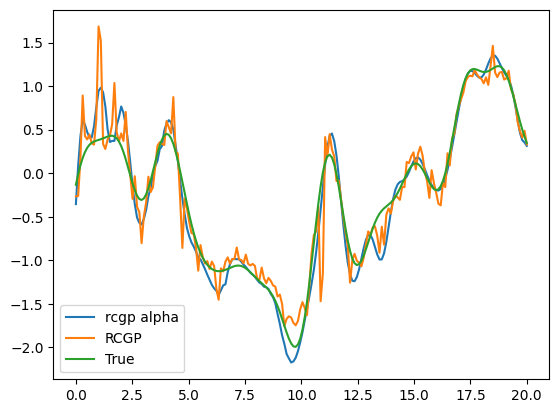

In [12]:


#plt.plot(x,pred,label="pred")

plt.plot(X,Mu_full,label="rcgp alpha")
#plt.plot(x, f_mean,label="GP")
plt.plot(x, f_mean_dsm,label="RCGP")
plt.plot(x,f,label="True")
plt.legend()

In [13]:
print(sum((Mu_full-f)**2))
print(sum((f_mean_dsm-f)**2))
print(sum((f_mean-f)**2))
print(sum((f-pred)**2))

tf.Tensor([6.79669367], shape=(1,), dtype=float64)
tf.Tensor([11.82043389], shape=(1,), dtype=float64)
tf.Tensor([42.56270475], shape=(1,), dtype=float64)
tf.Tensor([9.7809834], shape=(1,), dtype=float64)
